In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from collections import Counter
import time
import operator
#nltk.download('stopwords')
#from nltk.corpus import stopwords

In [2]:
#Importing dataset with codes description
descr = pd.read_csv('desc.csv', encoding = "ISO-8859-1", sep = ';', dtype = str)
#descr.head()

In [3]:
descr = descr[['code', 'name', 'notes']]

In [4]:
descr_test = []
for i in range(len(descr)):
    if len(descr.iloc[i,0]) == 2:
        descr_test.append(descr.iloc[i])
pd.DataFrame(descr_test).head()

,code,name,notes
0,01,"Jordbruk og tjenester tilknyttet jordbruk, jak...",Denne næringen to basisaktiviteter: produksj...
72,02,Skogbruk og tjenester tilknyttet skogbruk,produksjon av rundtømmer og utnyttelse og in...
85,03,"Fiske, fangst og akvakultur","fiske og akvakultur, som dekker bruk av fisk..."
101,05,Bryting av steinkull og brunkull,minedrift under og over jorden og aktivitete...
108,06,Utvinning av råolje og naturgass,"produksjon av råolje, utvinning av olje av o..."


In [5]:
desc_y = pd.DataFrame(descr_test).iloc[:,0].values
desc_X = pd.DataFrame(descr_test).iloc[:,1].values
desc_X2 = pd.DataFrame(descr_test).iloc[:,2].values

In [6]:
for i in range(len(desc_X2)):
    if not pd.isnull(desc_X2[i]):
        pos = desc_X2[i].find('Ekskluderer: ')
        if pos != -1: 
            desc_X2[i] = desc_X2[i][1:(pos-1)].lower().replace('omfatter ', '')
        else:
            desc_X2[i] = desc_X2[i][1:].lower().replace('omfatter ', '')

desc_X2[0]

'denne næringen  to basisaktiviteter: produksjon av vegetabilske og animalske produkter, jordbruk, dyrking av genetisk modifiserte vekster og oppdrett av genetisk modifiserte dyr. både dyrking av vekster på friland og i veksthus inngår i  også tjenester tilknyttet jordbruk, jakt og fangst'

In [7]:
#Importing dataset with company's descriptions
dataset = pd.read_csv('BESK_ALLE.csv', encoding = "ISO-8859-1", sep=';', dtype = 'str')

In [8]:
dataset = dataset[:1575675]

In [9]:
dataset = dataset[~dataset.besk.isnull()]

In [10]:
#define y and X
X = dataset.iloc[:, 1].values
y = dataset.iloc[:, 0].values

In [11]:
X_desc = X
X_desc = np.concatenate((X_desc, desc_X), axis = None)
X_desc = np.concatenate((X_desc, desc_X2), axis = None)

In [12]:
y_2 = []
for i in range(len(y)):
    y_2.append(y[i][:2])
y_2.extend(desc_y)
y_2.extend(desc_y)
y_2 = np.array(y_2)

In [13]:
y_2 = y_2[~pd.DataFrame(X_desc)[0].isnull()]
X_desc = X_desc[~pd.DataFrame(X_desc)[0].isnull()]

In [15]:
del desc_X
del desc_X2
del desc_y
del descr
del descr_test

In [14]:
X_bag = np.array(X_desc)
del X_desc

In [16]:
labels_list = []
tmp = list(Counter(y).items())
for i in tmp:
    if i[1] < 2:
        labels_list.append(i[0])
del tmp
labels_list

['24.320', '51.220', '64.110', '01.120', '01.640', '64.910']

In [17]:
index_1 = np.where(pd.DataFrame(y)[0].isin(labels_list))
index_wo1 = np.where(~pd.DataFrame(y)[0].isin(labels_list))

In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import StratifiedShuffleSplit
sss =  StratifiedShuffleSplit(y[index_wo1], 1, test_size = 0.20, random_state = 0)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
index_train = list(sss)[0][0]
index_test = list(sss)[0][1]
del sss

In [20]:
#X sets for fatstext
X_train = X[index_1]
X_train = np.concatenate((X_train, X[index_wo1][index_train]), axis = None)
X_test = X[index_wo1][index_test]

In [21]:
#y sets for fatstext
y_train = y[index_1]
y_train = np.concatenate((y_train, y[index_wo1][index_train]), axis = None)
y_test = y[index_wo1][index_test]

In [22]:
#sets for RandomForest 
#after split to train_set is added desc_X, desc_X2
index_tmp = np.concatenate((index_1, list(range(len(X), len(X_bag)))), axis = None)

In [23]:
#X set for RandomForest
X_bag_train = X_bag[index_tmp]
X_bag_train = np.concatenate((X_bag_train, X_bag[index_wo1][index_train]), axis = None)
X_bag_test = X_bag[index_wo1][index_test]

In [24]:
#y set for RandomForest
y_2_train = y_2[index_tmp]
y_2_train = np.concatenate((y_2_train, y_2[index_wo1][index_train]), axis = None)
y_2_test = y_2[index_wo1][index_test]

In [25]:
#file for 2 1st digits prediction
pd.DataFrame([X_bag_train[i] + ' __label__' + y_2_train[i] for i in range(len(X_bag_train))]).to_csv('ft_input_2_train.csv', encoding = "utf-8", index = None, header = None)

In [26]:
del index_tmp
del index_train
del index_test
del index_wo1
del index_1

In [27]:
import fastText
from fastText import train_supervised, tokenize, load_model, unicode_literals
import io

In [28]:
#loading for pretrained vector
#ISO-8859-1
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    fin.close()
    return data

In [29]:
ts_before = time.time()
#from Paul's code
#model for 2 first digits
model_2 = train_supervised(
    input = 'ft_input_2_train.csv',
    wordNgrams = 3,
    #label = '__label__',
    verbose = 2,
    minCount = 1, # minimal number of word occurences
    neg = 10, #number of negatives sampled
    dim = 300,
    pretrainedVectors = 'cc.nn.300.vec'
)
ts_after = time.time()
print(ts_after - ts_before)

284.21161437034607


In [30]:
#y for 2 first digits
y_2_pred = []
for i in range(len(X_test)):
    pred = model_2.predict(X_test[i])[0][0]
    y_2_pred.append(pred[9:11])

In [31]:
#see model work
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
def metrics_score(test, pred):
    print('accuracy: ', accuracy_score(test, pred))
    print('precision: ', precision_score(test, pred, average='macro'))
    print('recall: ', recall_score(test, pred, average='macro'))
    print('f1: ', f1_score(test, pred, average='macro'))

In [32]:
metrics_score(y_2_test, y_2_pred)

accuracy:  0.658020581786103


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.5568333791122909
recall:  0.3903168329015362
f1:  0.4281319205469433


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
labels = np.unique(y_2_test)

In [34]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_2_test, y_2_pred, labels)

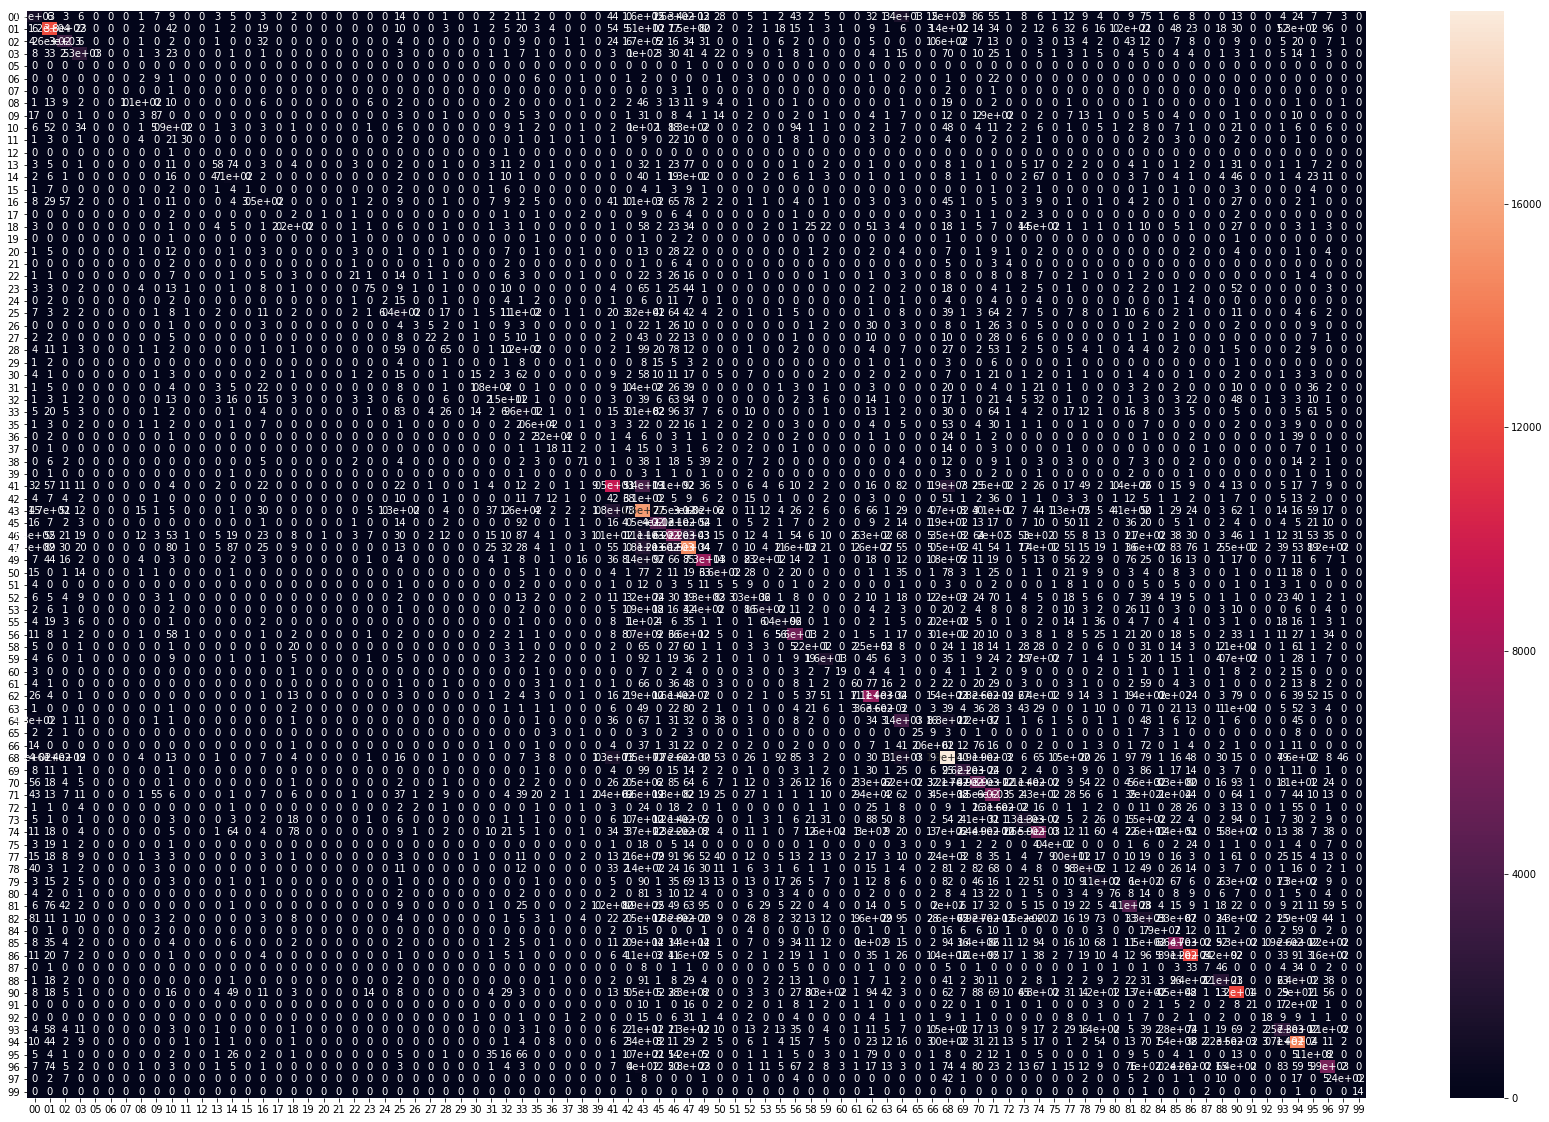

In [35]:
fig = plt.figure(figsize = (30,20))
import seaborn as sn
sn.heatmap(pd.DataFrame(cm, index = labels, columns = labels), annot = True)

In [36]:
pd.DataFrame([X_train[i] + ' __label__' + y_train[i] for i in range(len(X_train))]).to_csv('ft_input_train.csv', encoding = "utf-8", index = None, header = None)

In [37]:
#model for 5 digits
ts_before = time.time()
#from Paul's code
model = train_supervised(
    input = 'ft_input_train.csv',
    wordNgrams = 3,
    #label = '__label__',
    verbose = 2,
    minCount = 1, # minimal number of word occurences
    neg = 10, #number of negatives sampled
    dim = 300,
    pretrainedVectors = 'cc.nn.300.vec'
)
ts_after = time.time()
print(ts_after - ts_before)

555.3583002090454


In [38]:
y_pred = []
for i in range(len(X_test)):
    pred = model.predict(X_test[i])[0][0]
    pos = pred.find('.')
    y_pred.append(pred[pos-2 :pos+4])

In [39]:
metrics_score(y_test, y_pred)

accuracy:  0.5231441962599919


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.25338802264439014
recall:  0.13402371826286757
f1:  0.15258320827871033


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
#2 level with Fasttext
ts_before = time.time()
y_lvl_pred = []
for t in range(len(X_test)):
    pred = model.predict(X_test[t], k = 50)
    #print(X_test[t])
    res = {}
    res.clear()
    
    for i in range(len(pred[0])):
        pred_2 = model_2.predict(X_bag_test[t], k = 50)
        for j in range(len(pred_2[0])):
            pos = pred[0][i].find('.')
            if pred[0][i][pos-2:pos] == pred_2[0][j][9:11]:
                res[pred[0][i][pos-2:pos + 4]] = pred_2[1][j] * pred[1][i]
                break
                
    y_lvl_pred.append(max(res.items(), key = operator.itemgetter(1))[0])
ts_after = time.time()
print(ts_after - ts_before)

2022.1694993972778


In [41]:
metrics_score(y_test, y_lvl_pred)

accuracy:  0.395014168620868


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision:  0.18412536525326273
recall:  0.11390981619780813
f1:  0.12657127841012572


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
